In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime

CMAP = "Blues"

# Land Change

This notebook uses changes in NDVI, EVI or Fractional Cover to identify land change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. Significant reductions in vegetation are coincident with land change. In some cases these changes could be deforestation. Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

# Import Data Cube API
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()#config = '/home/localuser/.datacube.conf')
dc = api.dc

from utils_dcal.data_cube_utilities.dc_display_map import display_map
from sac_utils.createAOI import create_lat_lon
from sac_utils.createindices import NDVI, EVI
from sac_utils.clean_mask import landsat_qa_clean_mask
from sac_utils.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic
#from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic
from deaAfricascripts.deafrica_plotting import rgb
#if S2
#from sac_utils.fractional_cover import frac_coverage_classify
#if L8
from utils_dcal.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
import matplotlib.pyplot as plt
from matplotlib.cm import RdYlGn, Greens
from sac_utils.fromDCALscripts import threshold_plot


In [3]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

In [4]:
#inputs
#options "LANDSAT_8" and "SENTINEL_2"
platform = "LANDSAT_8"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_crs = "EPSG:32760"
resolution = (-30, 30)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

# Select the baseline time period (start and end)
baseline_time_period = (datetime(2015,3,1), datetime(2016,2,1))

# Select the analysis time period (start and end)
analysis_time_period = (datetime(2016,3,1), datetime(2017,2,1))

# Select the cloud-free mosaic type
# Options are: max_ndvi, min_ndvi, median, most_recent_pixel, geomedian
# If a geomedian is selected, it will take much longer to process
# It is most common to use the max_ndvi or median for these land change analyses
# HINT: Consider max_ndvi mosaics for NDVI analyses and median mosaics for EVI analyses 
mosaic_type = "max_ndvi" 

In [5]:
if platform  in ["SENTINEL_2"]:
    product = 's2_esa_sr_granule'
    measurements = ["green","red","blue","nir","swir_1","swir_2","coastal_aerosol","scene_classification"]
elif platform in ["LANDSAT_8"]:    
    measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]
    product = 'ls8_usgs_sr_scene'
else:
    print("invalid platform")

In [6]:
#central area - do dates 2013- 2014 and 2018-2019
#aoi_wkt = "POLYGON ((177.42576599121094 -18.058395415674948, 177.5390625 -18.058395415674948, 177.5390625 -17.96567026450931, 177.42576599121094 -17.96567026450931, 177.42576599121094 -18.058395415674948))"
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"

In [7]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [8]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

# Load and Clean Data

>#### Load Data ( Baseline, Analysis) 

In [9]:
baseline_ds = dc.load(
    latitude = lat_extents,
    longitude = lon_extents,
    time = baseline_time_period,
    measurements = measurements,
    product = product,
    platform = platform,                         
    output_crs = output_crs,
    resolution = resolution
)


In [10]:
analysis_ds = dc.load(
    latitude = lat_extents,
    longitude = lon_extents,
    time = analysis_time_period,
    measurements = measurements,
    product = product,
    platform = platform,                         
    output_crs = output_crs,
    resolution = resolution
)

> #### Check if loads are valid

In [11]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [12]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [13]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

In [14]:
#add in if statement here to remove influence of swir1
##comment out for L8
if platform  in ["SENTINEL_2"]:
    baseline_ds = baseline_ds.rename({"swir_1": "swir1", "swir_2":"swir2"})
    analysis_ds = analysis_ds.rename({"swir_1": "swir1", "swir_2":"swir2"})

> #### Clean Data
> Generating boolean masks that highlight valid pixels
> Pixels must be cloud-free over land or water to be considered

In [15]:
#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform)
analysis_clean_mask = landsat_qa_clean_mask(analysis_ds, platform)

In [16]:
#mask products
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

>#### Mosaic
> Use clean masks in a time series composite

In [17]:
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "min_ndvi": create_min_ndvi_mosaic,
                   "geomedian": create_hdmedians_multiple_band_mosaic,
                   "most_recent_pixel": create_mosaic}

In [18]:
new_compositor = mosaic_function[mosaic_type]

In [19]:
baseline_composite = new_compositor(baseline_ds, clean_mask = baseline_clean_mask.values, no_data=float('nan'))
analysis_composite = new_compositor(analysis_ds, clean_mask = analysis_clean_mask.values, no_data=float('nan'))

In [20]:
baseline_clean_masked = landsat_qa_clean_mask(baseline_composite, platform)
baseline_composite = baseline_composite.where(baseline_clean_masked)

In [21]:
analysis_clean_masked = landsat_qa_clean_mask(analysis_composite, platform)
analysis_composite = analysis_composite.where(analysis_clean_masked)

(<Figure size 720x587.586 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c14a34cf8>)

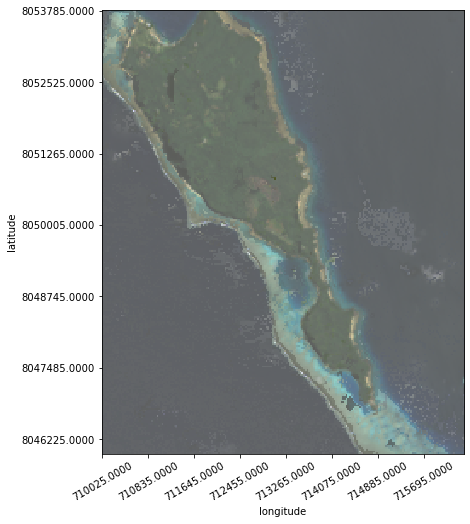

In [22]:
from utils_dcal.data_cube_utilities.dc_rgb import rgb
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude"})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude"})
rgb(baseline_composite, use_data_min=True, use_data_max=True)

(<Figure size 720x587.586 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c147d4be0>)

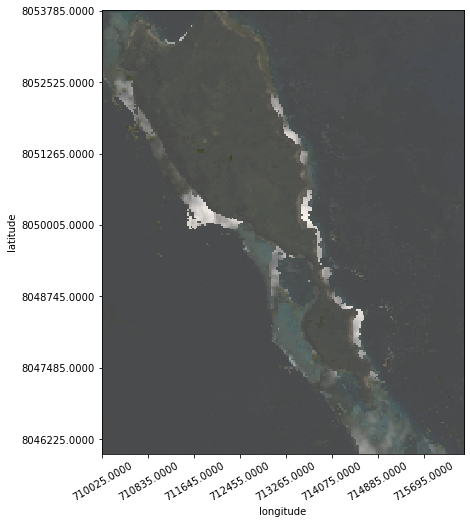

In [23]:
rgb(analysis_composite, use_data_min=True, use_data_max=True)

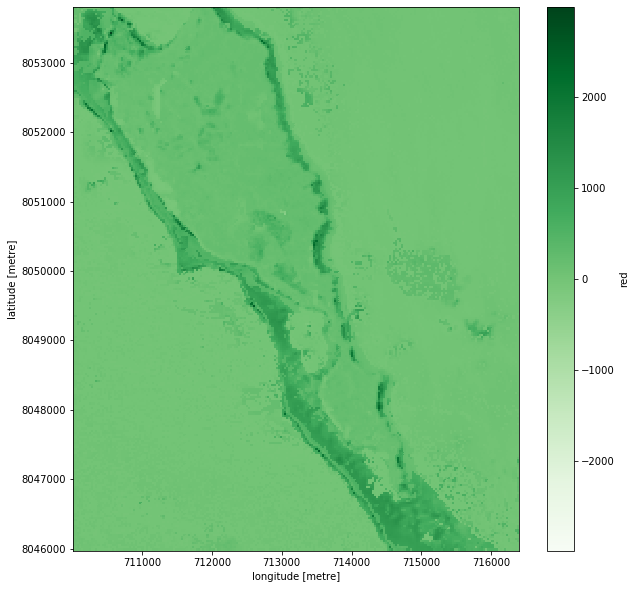

In [24]:
(baseline_composite.red).plot(figsize=(10,10),cmap = "Greens")

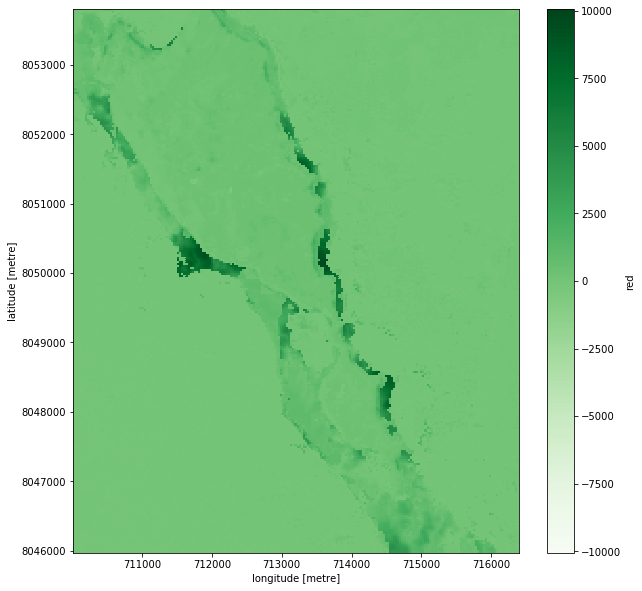

In [25]:
(analysis_composite.red).plot(figsize=(10,10),cmap = "Greens")

>## Plot a spectral index using the cloud-filtered mosaic

In [26]:
ndvi = NDVI(baseline_composite) 
evi = EVI(baseline_composite)

In [27]:
indices = 'evi'

if indices in ['ndvi', 'NDVI']:
    print("indices chosen is ndvi")
elif indices in ['EVI', 'evi']:
    print("indices chosen is EVI")
elif indices in ['FC']:
    print("indices chosen is FC")
else:
    print("indicies is invalid")

indices chosen is EVI


In [28]:
print(baseline_clean_masked)

<xarray.DataArray (y: 261, x: 213)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * y        (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x        (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05


In [29]:

if indices in ['FC']:
    frac_classes = frac_coverage_classify(baseline_composite, clean_mask = baseline_clean_masked.values, no_data=0) 
else:
    print('indices not fractional cover')
    

indices not fractional cover


In [30]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>

# Select a spectral index to plot by removing one of the comment tags (#) below
# Adjust the scale of the output using vmin and vmax

#(ndvi).plot(figsize=(10,10),cmap = "Greens", vmin=0.3, vmax=1.0)
#(evi).plot(figsize=(10,10),cmap = "Greens", vmin=1.75, vmax=2.5)
#(frac_classes.pv).plot(figsize=(10,10),cmap = "Greens", vmin=70.0, vmax=100.0)

In [31]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select a baseline threshold range for a given parameter ... which is basically a "mask"
# The analysis will only consider pixels in this range for change detection
# No data or cloud pixels will also be masked in this process

# If you want to see all change, you should select the full range of values for each parameter
# NDVI full range = 0.0 to 1.0
# EVI full range = 0.0 to 2.5
# Fractional Cover full range = 0.0 to 100.0

# If you want to mask out dense vegetation, typical of forested land, use the values below
# NDVI: 0.7 to 1.0
# EVI: 2.0 to 2.5



In [32]:
def determineThresholdRange(indices):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['ndvi', 'NDVI']:
        baseline_threshold_range = (0.7, 1.0) 
        a = (NDVI(baseline_composite))
    elif indices in ['EVI', 'evi']:
        baseline_threshold_range = (2, 2.5)
        a = (EVI(baseline_composite))
    elif indices in ['FC']:
        baseline_threshold_range = (70, 100)
        a = frac_classes.pv
    else:
        print('indicies not valid')
    _min, _max = baseline_threshold_range
    baseline_filter_mask = np.logical_and(a > _min, a < _max) 
    return baseline_filter_mask 

In [33]:
baseline_filter_mask = determineThresholdRange(indices)


In [34]:

RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

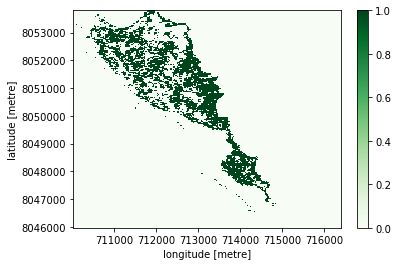

In [35]:
# This is the baseline threshold plot that shows GREEN pixels in the threshold range
# Pixels with values outside the threshold range are white 

#plt.figure(figsize = aspect_ratio_helper(baseline_filter_mask)) 
baseline_filter_mask.plot(cmap = "Greens")

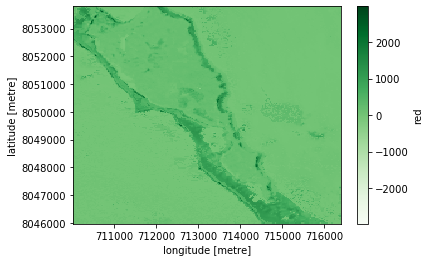

In [36]:
baseline_composite.red.plot(cmap = "Greens")

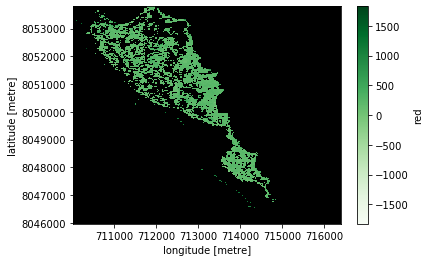

In [37]:
baseline_composite = baseline_composite.where(baseline_filter_mask)
baseline_composite.red.plot(cmap = "Greens")

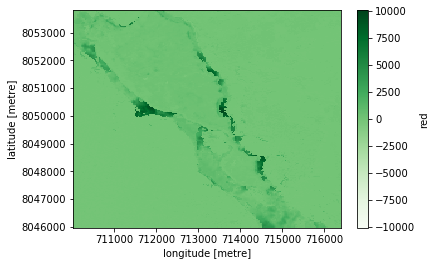

In [38]:
#analysis_composite = analysis_composite.where(analysis_filter_mask)
analysis_composite.red.plot(cmap = "Greens")

# Spectral Parameter Anomaly

In [39]:
from utils_dcal.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
#from sac_utils.fractional_cover import frac_coverage_classify 
#odc-hub/utils_sac/.py

In [40]:
def createparametercomposite(indices, baseline, analysis):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['ndvi']:
        parameter_baseline_composite = NDVI(baseline)
        parameter_analysis_composite = NDVI(analysis)
    elif indices in ['EVI', 'evi']:
        parameter_baseline_composite = EVI(baseline)
        parameter_analysis_composite = EVI(analysis)
    elif indices in ['FC']:
        parameter_baseline_composite = frac_coverage_classify(baseline, clean_mask = baseline_clean_masked.values, no_data=0) 
        parameter_analysis_composite = frac_coverage_classify(analysis, clean_mask = baseline_clean_masked.values, no_data=0)  
        parameter_baseline_composite = parameter_baseline_composite.pv
        parameter_analysis_composite = parameter_analysis_composite.pv
    return parameter_baseline_composite, parameter_analysis_composite

In [41]:
parameter_baseline_composite, parameter_analysis_composite = createparametercomposite(indices, baseline_composite, analysis_composite )

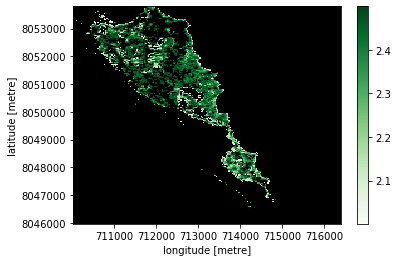

In [42]:
parameter_baseline_composite.plot(cmap = "Greens")

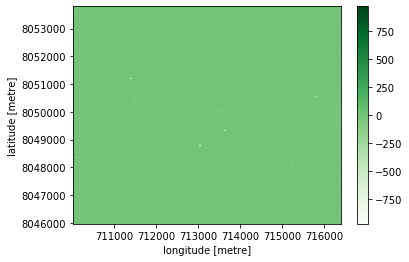

In [43]:
parameter_analysis_composite.plot(cmap = "Greens")

In [44]:
parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

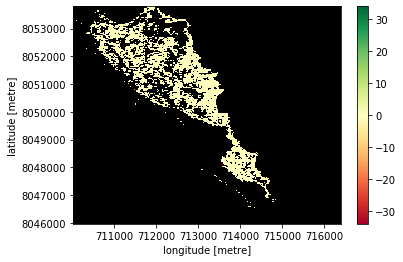

In [45]:
# Plot the parameter change from the baseline to the analysis period
# Significant loss in vegetation will be shown in RED
# Gains in vegetation will be shown in GREEN

#plt.figure(figsize = aspect_ratio_helper(parameter_anomaly)) 
parameter_anomaly.plot(cmap = RdYlGn)

# Anomaly Threshold Product

In [46]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select an Anomaly Threshold Range to filter the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)
# Losses are typically in these ranges for deforestation


In [47]:
def changeAnomalyRange(indices):
    '''Return the baseline_threshold_range based on indicies input.
    '''
    if indices in ['ndvi']:
        minC = -0.7
        maxC = -0.2
    elif indices in ['EVI', 'evi']:
        minC = -1.75
        maxC = -0.5
    elif indices in ['FC']:
        minC = -70
        maxC = -20
    return minC, maxC

In [48]:
# Create a threshold plot using the MIN and MAX range defined above
minimum_change, maximum_change = changeAnomalyRange(indices)

In [49]:
no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values))

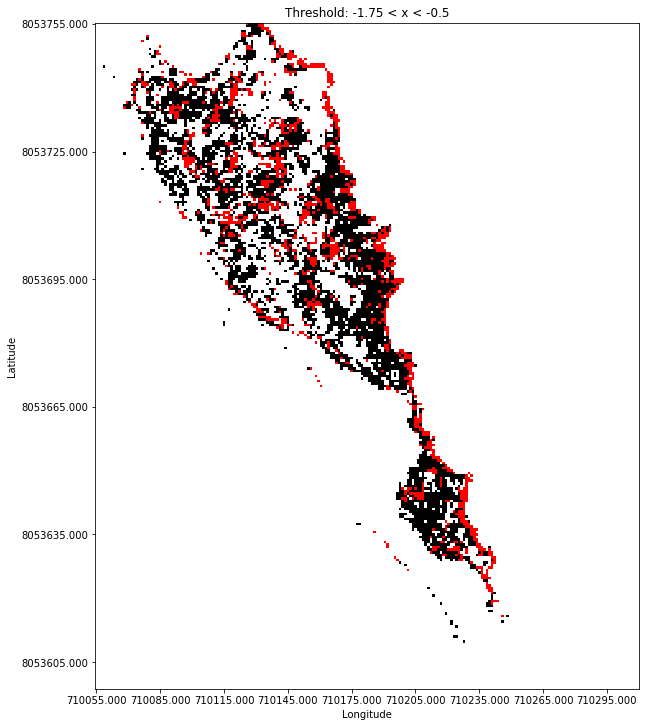

In [50]:
# Plot the parameter change using thresholds and 3 colors 
# RED = data in the threshold range (significant land change)
# BLACK = data outside the threshold range (no significant change)
# WHITE = data outside the baseline mask (not dense vegetation) or clouds (no data)
#parameter_anomaly = parameter_anomaly.rename({"x":"latitude", "y":"longitude"})
threshold_plot(parameter_anomaly, minimum_change, maximum_change, mask = no_data_mask, width  = 10)

In [51]:
from utils_dcal.data_cube_utilities.import_export import export_slice_to_geotiff

In [52]:
from utils_dcal.data_cube_utilities.dc_utilities import write_png_from_xr, write_geotiff_from_xr

In [53]:
# CHANGE HERE >>>>>>>>>>>>>

write_geotiff_from_xr('ndvi_test.tiff', parameter_anomaly, crs=output_crs)